<a href="https://colab.research.google.com/github/talhaanwarch/Plant-Leaf-Disease-Classification/blob/master/transfer_learning_pipeline_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### download data

In [1]:
!wget https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip

--2020-04-01 01:05:20--  https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86, 2606:4700:7::a29f:8256, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb [following]
--2020-04-01 01:05:21--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.37.152
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.37.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66977095 (64M)

### unzip donwloaded dataset

In [2]:
!unzip /content/Citrus.zip

Archive:  /content/Citrus.zip
   creating: Citrus/
   creating: Citrus/Fruits/
   creating: Citrus/Fruits/Black spot/
  inflating: Citrus/Fruits/Black spot/Black spot (1).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (10).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (11).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (12).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (13).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (14).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (15).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (16).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (17).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (18).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (19).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (2).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (3).jpg  
  inflating: Citrus/Fruits/Black spot/Black spot (4).jpg  
  inflating: Citrus/Fruits/Black spot/Black sp

## import libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.applications import densenet,inception_resnet_v2

## data augmentation 

In [0]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

In [0]:
img_shape=299
batch_size=24

# Leaves

In [7]:
#load the training data
leaves_train_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)


Found 429 images belonging to 5 classes.


In [8]:
#load the training data
val_suffle=False
leaves_val_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350


Found 180 images belonging to 5 classes.


In [9]:
leaves_train_generator.next()[0].shape,leaves_train_generator.next()[1].shape

((24, 299, 299, 3), (24, 5))

In [10]:
leaves_val_generator.next()[0].shape,leaves_val_generator.next()[1].shape

((24, 299, 299, 3), (24, 5))

### Base model

In [11]:
leaves_model =inception_resnet_v2.InceptionResNetV2(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))


219062272/219055592 [==============================] - 5s 0us/step


In [0]:
x = leaves_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
leaves_model = Model(inputs=leaves_model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
leaves_model.compile(optimizer='adam', loss=custom_loss, metrics=['categorical_accuracy'])

In [16]:

trainable_count = np.sum([K.count_params(w) for w in leaves_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in leaves_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 54,542,053
Trainable params: 54,481,509
Non-trainable params: 60,544


In [17]:
results = leaves_model.fit(leaves_train_generator,epochs=15,
                              steps_per_epoch=leaves_train_generator.n/batch_size,
                              validation_data=leaves_val_generator,
                             validation_steps=leaves_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/15
18/17 [==============================] - 29s 2s/step - loss: 1.1597 - categorical_accuracy: 0.5664 - val_loss: 47.2874 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 2/15
18/17 [==============================] - 21s 1s/step - loss: 0.8474 - categorical_accuracy: 0.8182 - val_loss: 284.5239 - val_categorical_accuracy: 0.0278 - lr: 0.0010
Epoch 3/15
18/17 [==============================] - 21s 1s/step - loss: 0.7103 - categorical_accuracy: 0.8741 - val_loss: 74.0768 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 4/15
18/17 [==============================] - 21s 1s/step - loss: 0.6750 - categorical_accuracy: 0.8974 - val_loss: 4.6048 - val_categorical_accuracy: 0.4944 - lr: 3.0000e-04
Epoch 5/15
18/17 [==============================] - 21s 1s/step - loss: 0.6157 - categorical_accuracy: 0.9138 - val_loss: 0.8907 - val_categorical_accuracy: 0.8389 - lr: 3.0000e-04
Epoch 6/15
18/17 [==============================] - 21s 1s/step - loss: 0.5861 - categorical_accuracy: 

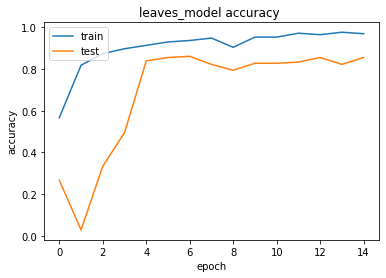

In [18]:

plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('leaves_model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

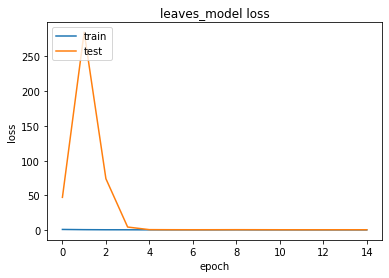

In [19]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('leaves_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
leaves_model.evaluate(leaves_val_generator,steps=leaves_val_generator.n//batch_size)

7/7 [==============================] - 4s 516ms/step - loss: 0.6525 - categorical_accuracy: 0.8526


[0.6525489091873169, 0.8525640964508057]

In [21]:
leaves_val_generator.reset()
leaves_model.evaluate(leaves_val_generator,steps=leaves_val_generator.n//batch_size)

7/7 [==============================] - 4s 561ms/step - loss: 0.7215 - categorical_accuracy: 0.8571


[0.721545398235321, 0.8571428656578064]

In [22]:
leaves_val_generator.reset()
y_pred=leaves_model.predict(leaves_val_generator,steps=leaves_val_generator.n/batch_size,verbose=1)

8/7 [================================] - 4s 536ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(leaves_val_generator.n)
  leaves_val_generator.index_array = per
  y_true = leaves_val_generator.classes[per]
else: 
  y_true = leaves_val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [25]:
y_pred.shape,y_true.shape

((180,), (180,))

In [26]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8611111111111112
0.9040489213756541


In [27]:
class_label=list(leaves_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.84      0.82      0.83        51
    Melanose       1.00      1.00      1.00         3
      canker       0.97      0.81      0.89        48
    greening       0.78      0.89      0.83        61
     healthy       0.94      1.00      0.97        17

    accuracy                           0.86       180
   macro avg       0.91      0.90      0.90       180
weighted avg       0.87      0.86      0.86       180



In [0]:
leaves_model.save('leave_model.h5')

# Fruit

In [29]:
#load the training data
fruits_train_generator = data_gen.flow_from_directory(
    '/content/Citrus/Fruits',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)


Found 108 images belonging to 5 classes.


In [30]:
#load the training data
val_suffle=False
fruits_val_generator = data_gen.flow_from_directory(
    '/content/Citrus/Fruits',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350


Found 42 images belonging to 5 classes.


In [31]:
fruits_train_generator.next()[0].shape,fruits_train_generator.next()[1].shape

((24, 299, 299, 3), (24, 5))

In [32]:
fruits_val_generator.next()[0].shape,fruits_val_generator.next()[1].shape

((24, 299, 299, 3), (18, 5))

### Base model

In [0]:
fruit_model =inception_resnet_v2.InceptionResNetV2(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))


In [0]:
x = fruit_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
fruit_model = Model(inputs=fruit_model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
fruit_model.compile(optimizer='adam', loss=custom_loss, metrics=['categorical_accuracy'])

In [38]:

trainable_count = np.sum([K.count_params(w) for w in fruit_model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in fruit_model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 54,542,053
Trainable params: 54,481,509
Non-trainable params: 60,544


In [39]:
results = fruit_model.fit(fruits_train_generator,epochs=15,
                              steps_per_epoch=fruits_train_generator.n/batch_size,
                              validation_data=fruits_val_generator,
                             validation_steps=fruits_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)])

Epoch 1/15
5/4 [=================================] - 12s 2s/step - loss: 1.4415 - categorical_accuracy: 0.5093 - val_loss: 1.6604 - val_categorical_accuracy: 0.4048 - lr: 0.0010
Epoch 2/15
5/4 [=================================] - 6s 1s/step - loss: 1.0683 - categorical_accuracy: 0.6759 - val_loss: 12.1454 - val_categorical_accuracy: 0.2381 - lr: 0.0010
Epoch 3/15
5/4 [=================================] - 6s 1s/step - loss: 1.0576 - categorical_accuracy: 0.6944 - val_loss: 142.2689 - val_categorical_accuracy: 0.1190 - lr: 0.0010
Epoch 4/15
5/4 [=================================] - 6s 1s/step - loss: 0.9085 - categorical_accuracy: 0.7778 - val_loss: 112.5717 - val_categorical_accuracy: 0.5714 - lr: 3.0000e-04
Epoch 5/15
5/4 [=================================] - 6s 1s/step - loss: 0.8912 - categorical_accuracy: 0.7593 - val_loss: 35.7751 - val_categorical_accuracy: 0.5476 - lr: 3.0000e-04
Epoch 6/15
5/4 [=================================] - 6s 1s/step - loss: 0.8022 - categorical_accurac

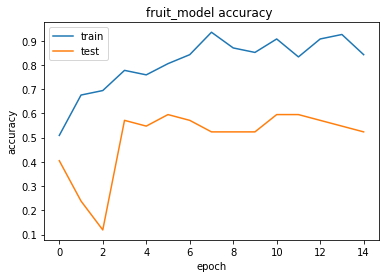

In [40]:

plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('fruit_model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

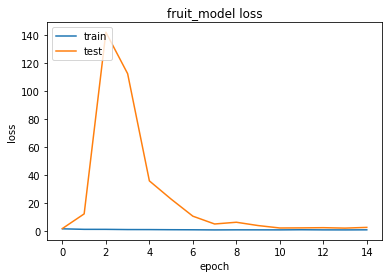

In [41]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('fruit_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
fruit_model.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

1/1 [==============================] - 0s 6ms/step - loss: 3.7176 - categorical_accuracy: 0.2778


[3.7176170349121094, 0.2777777910232544]

In [43]:
fruits_val_generator.reset()
fruit_model.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

1/1 [==============================] - 0s 2ms/step - loss: 1.1731 - categorical_accuracy: 0.7917


[1.17314612865448, 0.7916666865348816]

In [44]:
fruits_val_generator.reset()
y_pred=fruit_model.predict(fruits_val_generator,steps=fruits_val_generator.n/batch_size,verbose=1)

2/1 [==================================] - 0s 215ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(fruits_val_generator.n)
  fruits_val_generator.index_array = per
  y_true = fruits_val_generator.classes[per]
else: 
  y_true = fruits_val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [47]:
y_pred.shape,y_true.shape

((42,), (42,))

In [48]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.5476190476190477
0.2196825396825397


In [49]:
class_label=list(fruits_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.00      0.00      0.00         5
      Canker       0.55      0.96      0.70        23
    Greening       0.00      0.00      0.00         4
        Scab       1.00      0.25      0.40         4
     healthy       0.00      0.00      0.00         6

    accuracy                           0.55        42
   macro avg       0.31      0.24      0.22        42
weighted avg       0.40      0.55      0.42        42



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model Transfer
Leave model to Fruit model

In [0]:
leave2fruit =inception_resnet_v2.InceptionResNetV2(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))


In [0]:
x = leave2fruit.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
leave2fruit = Model(inputs=leave2fruit.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
leave2fruit.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['categorical_accuracy'])

In [0]:
leave2fruit.load_weights('leave_model.h5')

In [56]:

trainable_count = np.sum([K.count_params(w) for w in leave2fruit.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in leave2fruit.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 54,542,053
Trainable params: 54,481,509
Non-trainable params: 60,544


In [57]:
results = leave2fruit.fit(fruits_train_generator,epochs=15,
                              steps_per_epoch=fruits_train_generator.n/batch_size,
                              validation_data=fruits_val_generator,
                             validation_steps=fruits_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.000001)])

Epoch 1/15
5/4 [=================================] - 8s 2s/step - loss: 2.7751 - categorical_accuracy: 0.0741 - val_loss: 1.3704 - val_categorical_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 2/15
5/4 [=================================] - 6s 1s/step - loss: 1.9644 - categorical_accuracy: 0.1296 - val_loss: 1.3225 - val_categorical_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 3/15
5/4 [=================================] - 5s 1s/step - loss: 1.5995 - categorical_accuracy: 0.2685 - val_loss: 1.2951 - val_categorical_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 4/15
5/4 [=================================] - 6s 1s/step - loss: 1.5008 - categorical_accuracy: 0.3889 - val_loss: 1.2908 - val_categorical_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 5/15
5/4 [=================================] - 6s 1s/step - loss: 1.4348 - categorical_accuracy: 0.5000 - val_loss: 1.3207 - val_categorical_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 6/15
5/4 [=================================] - 6s 1s/step - loss: 1.3554 - categorical_ac

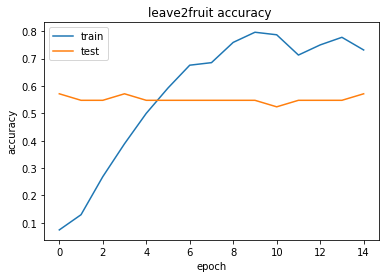

In [58]:

plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('leave2fruit accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

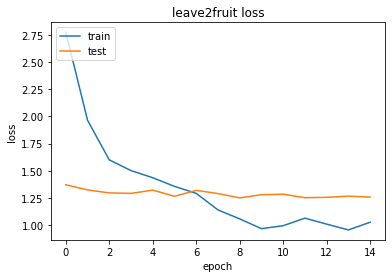

In [59]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('leave2fruit loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
leave2fruit.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

1/1 [==============================] - 0s 1ms/step - loss: 0.8360 - categorical_accuracy: 0.7500


[0.836029589176178, 0.75]

In [61]:
fruits_val_generator.reset()
leave2fruit.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

1/1 [==============================] - 0s 6ms/step - loss: 0.8183 - categorical_accuracy: 0.7500


[0.8183493614196777, 0.75]

In [62]:
fruits_val_generator.reset()
y_pred=leave2fruit.predict(fruits_val_generator,steps=fruits_val_generator.n/batch_size,verbose=1)

2/1 [==================================] - 0s 227ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(fruits_val_generator.n)
  fruits_val_generator.index_array = per
  y_true = fruits_val_generator.classes[per]
else: 
  y_true = fruits_val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1).astype(np.int32)

In [65]:
y_pred.shape,y_true.shape

((42,), (42,))

In [66]:
print("preds: {}, {}".format(y_pred.dtype, y_pred.shape))
print("actual: {}, {}".format(y_true.dtype, y_true.shape))

preds: int32, (42,)
actual: int32, (42,)


In [67]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.5476190476190477
0.2615384615384615


In [68]:
class_label=list(fruits_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.14      0.20      0.17         5
      Canker       0.72      0.91      0.81        23
    Greening       0.50      0.25      0.33         4
        Scab       0.00      0.00      0.00         4
     healthy       0.00      0.00      0.00         6

    accuracy                           0.55        42
   macro avg       0.27      0.27      0.26        42
weighted avg       0.46      0.55      0.49        42



## Fine tuning
Leave model to Fruit model

In [0]:
leave2fruit =inception_resnet_v2.InceptionResNetV2(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))
x = leave2fruit.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
leave2fruit = Model(inputs=leave2fruit.input, outputs=predictions)
leave2fruit.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['categorical_accuracy'])
leave2fruit.load_weights('leave_model.h5')

In [0]:
for layer in leave2fruit.layers[:-6]:
    layer.trainable = False

In [72]:
results = leave2fruit.fit(fruits_train_generator,epochs=15,
                              steps_per_epoch=fruits_train_generator.n/batch_size,
                              validation_data=fruits_val_generator,
                             validation_steps=fruits_val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.000001)])

Epoch 1/15
5/4 [=================================] - 9s 2s/step - loss: 2.5960 - categorical_accuracy: 0.1204 - val_loss: 1.3614 - val_categorical_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 2/15
5/4 [=================================] - 6s 1s/step - loss: 1.8380 - categorical_accuracy: 0.2778 - val_loss: 1.4336 - val_categorical_accuracy: 0.6190 - lr: 1.0000e-04
Epoch 3/15
5/4 [=================================] - 6s 1s/step - loss: 1.5621 - categorical_accuracy: 0.3519 - val_loss: 1.3400 - val_categorical_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 4/15
5/4 [=================================] - 6s 1s/step - loss: 1.3802 - categorical_accuracy: 0.5556 - val_loss: 1.3865 - val_categorical_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 5/15
5/4 [=================================] - 6s 1s/step - loss: 1.2676 - categorical_accuracy: 0.6481 - val_loss: 1.4200 - val_categorical_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 6/15
5/4 [=================================] - 6s 1s/step - loss: 1.2709 - categorical_ac

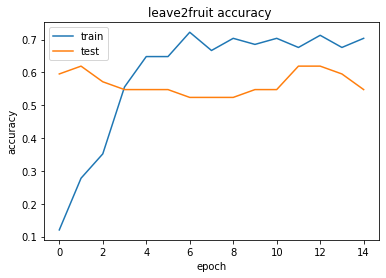

In [73]:

plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('leave2fruit accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

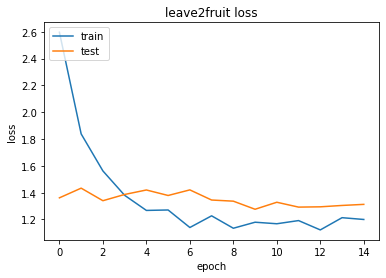

In [74]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('leave2fruit loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
fruits_val_generator.reset()
leave2fruit.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

1/1 [==============================] - 0s 2ms/step - loss: 0.9181 - categorical_accuracy: 0.7500


[0.9180684685707092, 0.75]

In [76]:
fruits_val_generator.reset()
leave2fruit.evaluate(fruits_val_generator,steps=fruits_val_generator.n//batch_size)

1/1 [==============================] - 0s 3ms/step - loss: 0.9057 - categorical_accuracy: 0.7500


[0.9057249426841736, 0.75]

In [77]:
fruits_val_generator.reset()
y_pred=leave2fruit.predict(fruits_val_generator,steps=fruits_val_generator.n/batch_size,verbose=1)

2/1 [==================================] - 0s 212ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(fruits_val_generator.n)
  fruits_val_generator.index_array = per
  y_true = fruits_val_generator.classes[per]
else: 
  y_true = fruits_val_generator.classes

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [80]:
y_pred.shape,y_true.shape

((42,), (42,))

In [81]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.5714285714285714
0.33367965367965363


In [82]:
class_label=list(fruits_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.00      0.00      0.00         5
      Canker       0.66      0.91      0.76        23
    Greening       0.67      0.50      0.57         4
        Scab       0.50      0.25      0.33         4
     healthy       0.00      0.00      0.00         6

    accuracy                           0.57        42
   macro avg       0.36      0.33      0.33        42
weighted avg       0.47      0.57      0.50        42



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
